In [173]:
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import json
from PIL import Image
import os
import io
from google.cloud import storage
import torch
import torchvision
import numpy as np
import matplotlib.patches as patches

In [174]:
class FishnetDataset(Dataset):
    def __init__(self, labels_file, bucket_name, gcp_cred_path, transform=None, resize_shape: tuple = (400, 800)):
        self.label_dict = json.load(open(labels_file))
        self.label_list = list(self.label_dict.keys())
        self.bucket_name = bucket_name
        self.transform = transform
        os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = gcp_cred_path
        self.storage_client = storage.Client()
        self.bucket = self.storage_client.bucket(bucket_name)
        self.resize_shape = resize_shape

    def __len__(self):
        return len(self.label_dict)

    def __getitem__(self, idx):
        blob = self.bucket.blob(self.label_list[idx] + ".jpg")
        img_bytes = blob.download_as_bytes()

        # Convert bytes to an image
        img = Image.open(io.BytesIO(img_bytes)).convert('RGB')

        # Find the resizing scales for x and y
        x_scale = self.resize_shape[1] / img.size[0]
        y_scale = self.resize_shape[0] / img.size[1]

        # Transform, if any
        if self.transform:
            img = self.transform(img)

        # Get the label
        target = self.label_dict[self.label_list[idx]][1]

        # Scale the bounding boxes
        for i in range(len(target)):
            for j in range(2):
                target[i][0][j] = str(int(int(target[i][0][j]) * x_scale))
                target[i][1][j] = str(int(int(target[i][1][j]) * y_scale))

        # Pad the target with missing values
        while len(target) < 20:
            target.append([["-1","-1"], ["-1","-1"], "Missing"])

        return img, target


In [175]:
def display_bounding_boxes(input_image: torch.Tensor, model_outputs: dict, thresh = 0.8):

    boxes = model_outputs[0]['boxes']
    cleaned_boxes = []
    for box in boxes:
        box = box.detach().numpy()
        box = box.astype(int)
        cleaned_boxes.append(box)

    scores = model_outputs[0]['scores']
    for i in range(len(scores)):
        if scores[i] < thresh:
            cleaned_boxes[i] = None
            
    cleaned_boxes = [box for box in cleaned_boxes if box is not None]

    # Create figure and axes
    fig, ax = plt.subplots()
    # Display the image
    ax.imshow(input_image[0].permute(1, 2, 0))

    # Create a Rectangle patch for each cleaned box and add to the plot
    for box in cleaned_boxes:
        rect = patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)


In [176]:
from torchvision import transforms
from torch.utils.data import DataLoader

# Define the transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((400, 800))
])

# Create the dataset
dataset = FishnetDataset(labels_file="../data/labels.json", 
                         bucket_name="fishnet3-object-detection", 
                         gcp_cred_path="../fishnet3-56e06381ff35.json", 
                         transform=transform,
                         resize_shape=(400, 800))


In [177]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [204]:
# Create train, val, test splits
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

# Create the dataloaders
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


IndexError: list index out of range

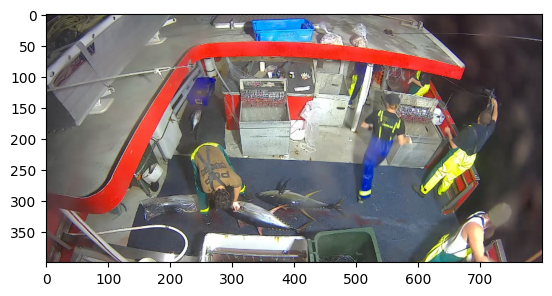

In [205]:

# Get a batch of training data
inputs, targets = next(iter(train_loader))

# For each image in the imputs, display it by itself
for i in range(len(inputs)):
    img = inputs[i]
    img = img.permute(1, 2, 0)
    plt.imshow(img)
    # Draw the bounding boxes
    target = targets[i]
    print   

    for box in target:
        if box[2] == "Missing":
            continue
        xs = box[0]
        ys = box[1]
        xs = [int(x) for x in xs]
        ys = [int(y) for y in ys]

        rect = patches.Rectangle((xs[0], ys[0]), xs[1]-xs[0], ys[1]-ys[0], linewidth=1, edgecolor='r', facecolor='none')
        plt.gca().add_patch(rect)


    plt.show()



plt.show()

In [ ]:
def transform_targets_fixed(raw_targets):
    # Define a mapping from class names to class IDs (assuming 'Human' is class 1)
    class_to_id = {'Human': 0, 'Swordfish': 1, 'Albacore': 2, 'Yellowfin tuna': 3, 'No fish': 4, 'Mahi mahi': 5, 'Skipjack tuna': 6, 'Unknown': 7, 'Wahoo': 8, 'Bigeye tuna': 9, 'Striped marlin': 10, 'Opah': 11, 'Blue marlin': 12, 'Escolar': 13, 'Shark': 14, 'Tuna': 15, 'Water': 16, 'Oilfish': 17, 'Pelagic stingray': 18, 'Marlin': 19, 'Great barracuda': 20, 'Shortbill spearfish': 21, 'Indo Pacific sailfish': 22, 'Lancetfish': 23, 'Long snouted lancetfish': 24, 'Black marlin': 25}

    # Initialize lists to hold transformed targets
    boxes = []
    labels = []

    for item in raw_targets:
        # Check if the target is not 'Missing'
        if item[2] != 'Missing':
            # Convert coordinate strings to float and correctly order as (xmin, ymin, xmax, ymax)
            box = [float(item[0][0]), float(item[1][0]), float(item[0][1]), float(item[1][1])]
            boxes.append(box)
            # Convert class name to class ID and add to labels list
            labels.append(class_to_id[item[2]])

    # Convert lists to PyTorch tensors
    boxes_tensor = torch.tensor(boxes, dtype=torch.float32)
    labels_tensor = torch.tensor(labels, dtype=torch.int64)

    # Create the target dictionary
    target_dict = {'boxes': boxes_tensor, 'labels': labels_tensor}

    return target_dict

## Experimental Training Loop

In [206]:
from utils import calculate_total_loss_for_image
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [207]:
# Setup model and freeze the weights
model = fasterrcnn_resnet50_fpn(weights="FasterRCNN_ResNet50_FPN_Weights.DEFAULT")

for param in model.parameters():
    param.requires_grad = False

in_features = model.roi_heads.box_predictor.cls_score.in_features
num_classes = 26
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

model.to("cuda")

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [208]:
def train():
    # Define the optimizer and loss function
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.Adam(params, lr=0.001)

    # Train the model
    for epoch in range(3):
        for inputs, targets in train_loader:
            inputs = list(img.to("cuda") for img in inputs)
            targets = [transform_targets_fixed(target) for target in targets]
            targets = [{k: v.to("cuda") for k, v in t.items()} for t in targets]

            optimizer.zero_grad()

            # Forward pass
            loss_dict = model(inputs, targets)
            print("Aye we got a loss")

            # Compute total loss for backpropagation
            total_loss = sum(loss for loss in loss_dict.values())

            # Calculate the loss and backprop
            total_loss.backward()
            print("Did a backwarsd y a know")

            optimizer.step()

        print(f"Epoch {epoch} Loss: {total_loss.item()}")

In [209]:
train()

IndexError: list index out of range